In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU

In [2]:
Autoencoder = tf.keras.models.load_model('TAE_z3_best_model', compile=False)

In [3]:
phis=[0.93,1.0,1.10] 
Ts=[1160,1200,1130]

name_11='State_space_cte_pressure_T' 
name_12='_phi_'
name_21='Reaction_rates_cte_pressure_T'
name_22='_phi_'

end='.csv'

In [4]:
def hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values):
    cantera_sources=cantera_sources.add_suffix('w')
    cantera_sources=cantera_sources.iloc[:,1:] #for taking out the timestep as data 
    
    cantera_time=cantera_species.iloc[:,1]
    cantera_temperature=cantera_species.iloc[:,2]
    cantera_pressure=cantera_species.iloc[:,3]
    
    cantera_species_fractions=cantera_species.iloc[:,4:12]
    
    n_columns_mass_fraction=np.shape(cantera_species_fractions)[1]
    
    cantera_sources=cantera_sources.loc[:,(cantera_sources!=0).any(axis=0)]
    cantera_sources=cantera_sources.loc[:, (cantera_sources != cantera_sources.iloc[0]).any()]
    
    n_columns_source=np.shape(cantera_sources)[1]
    
    cantera_data=pd.concat([cantera_time, cantera_temperature,cantera_species_fractions,cantera_sources],axis=1)

    maximum_values=maximum_values.iloc[0,1:]
    maximum_values=maximum_values.to_numpy()
    
    iterations=np.shape(cantera_data)[1]
    
    #cantera_data.divide(maximum_values)
    for j in range(iterations):
        cantera_data.iloc[:,j]=cantera_data.iloc[:,j]/(maximum_values[j])
    
    cantera_data_shift=cantera_data.loc[1:,:]
    cantera_data_shift=cantera_data_shift.add_suffix('shift')
    
    cantera_data=cantera_data.reset_index()
    cantera_data_shift=cantera_data_shift.reset_index()
    
    cantera_data=cantera_data.iloc[:,1:]
    cantera_data_shift=cantera_data_shift.iloc[:,1:]

    cantera_data=cantera_data.iloc[0:(np.shape(cantera_data_shift)[0]),:]
    
    data_all=pd.concat([cantera_data, cantera_data_shift], axis=1)

    columns=data_all.columns.to_list()
    
    return data_all, n_columns_source, n_columns_mass_fraction, columns

In [5]:
k1=1
cantera_species=pd.read_csv(name_11+str(Ts[k1])+name_12+str(phis[k1])+end)
cantera_species=pd.DataFrame(cantera_species)

cantera_sources=pd.read_csv(name_21+str(Ts[k1])+name_22+str(phis[k1])+end)
cantera_sources=pd.DataFrame(cantera_sources)

maximum_values=pd.read_csv('maximum_values_Phi_T_Sampling.csv')
maximum_values=pd.DataFrame(maximum_values)

In [6]:
dataset, n_columns_source, n_columns_mass_fraction, columns=hydrogen_data_clean_shift_sandiego_cantera(cantera_species,cantera_sources,maximum_values)

In [7]:
results=Autoencoder.decoder(Autoencoder.lat_activation(Autoencoder.encoder(dataset.iloc[:,1:2+n_columns_mass_fraction].to_numpy()))).numpy()

In [8]:
interest_vector=['H2O','O2','H2','T[K]','OH','HO2','H2O2']

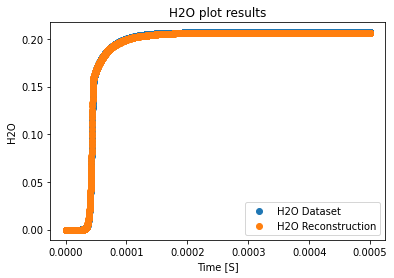

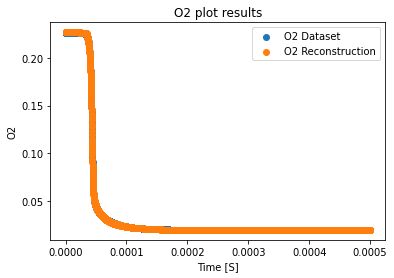

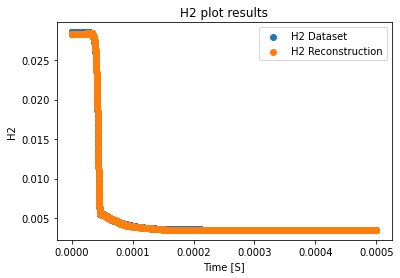

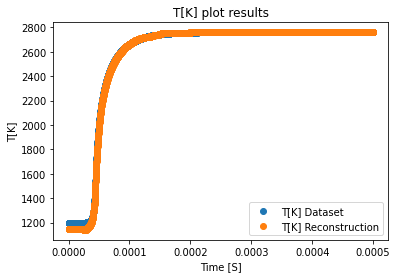

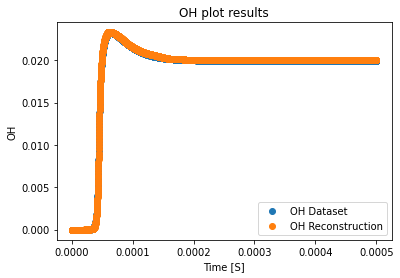

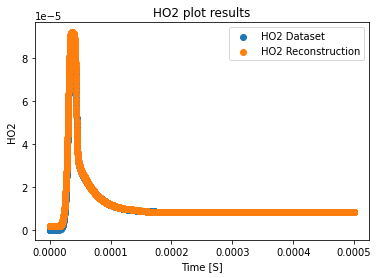

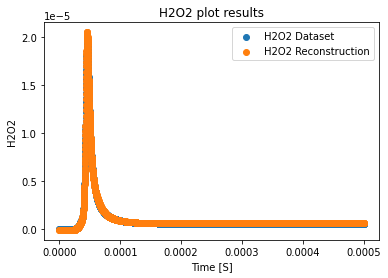

In [9]:
t_index=columns.index('t[s]shift')
t_trans=maximum_values.columns.get_loc('t[s]')
time_plot=(dataset.iloc[:,t_index])*maximum_values.iloc[0,t_trans]
    
for k in range(len(interest_vector)):
    original_index=columns.index(interest_vector[k]+'shift')
    #print(columns[original_index])
    results_index=columns.index(interest_vector[k]) #minues one due to the time column presence 
    #print(columns[results_index])
    #print(results_index-1)
    transformation_index=maximum_values.columns.get_loc(interest_vector[k])
    plot_name=interest_vector[k]+'.png'
    
    input_label=interest_vector[k]+' Dataset'
    output_label=interest_vector[k]+' Reconstruction'
    
    original=(dataset.iloc[:,original_index]).to_numpy()
    #original=original*transformation_values[1,original_index]
    #original=original+transformation_values[0,original_index]
    #original=np.exp(original)-1
    original=original*maximum_values.iloc[0,transformation_index]
    
    output=(results[:,results_index-1])
    #output=output*transformation_values[1,results_index]
    #output=output+transformation_values[0,results_index]
    #output=np.exp(output)-1
    output=output*maximum_values.iloc[0,transformation_index]
    
    plt.figure(k)
    plt.scatter(time_plot,original, label=input_label)
    plt.scatter(time_plot,output, label=output_label)
    plt.title(interest_vector[k]+' plot results')
    plt.xlabel('Time [S]')
    plt.ylabel(interest_vector[k])
    plt.legend()

In [10]:
scaling_factors=maximum_values.iloc[0,2:2+n_columns_mass_fraction+1].to_numpy()
scaling_factors

array([2.78491835e+03, 3.21998743e-02, 5.18511576e-03, 2.26904738e-01,
       2.34954458e-02, 1.77721948e-02, 2.22506271e-01, 1.13527252e-04,
       2.13688613e-05])

In [11]:
#calculating the original Lipschitz associated gradients 

output_start=3+n_columns_mass_fraction+n_columns_source
output_end=output_start+n_columns_mass_fraction+1

Inputs=dataset.iloc[:,1:2+n_columns_mass_fraction]
Outputs=dataset.iloc[:,output_start:output_end]

for i in range(np.shape(Inputs)[1]):
    Inputs.iloc[:,i]=Inputs.iloc[:,i]#*scaling_factors[i]
    Outputs.iloc[:,i]=Outputs.iloc[:,i]#*scaling_factors[i]

Inputs=Inputs.to_numpy()
Outputs=Outputs.to_numpy()

Original_gradients=np.subtract(Outputs,Inputs)

In [12]:
pd.DataFrame(Original_gradients)

,0,1,2,3,4,5,6,7,8
0,-3.145839e-10,-3.846909e-10,1.135595e-09,-8.881691e-10,1.239961e-10,1.996019e-10,9.373052e-12,1.756927e-06,1.089307e-09
1,-3.134234e-10,-3.977717e-10,1.137305e-09,-9.163864e-10,1.686022e-10,3.049339e-10,2.212010e-11,1.766113e-06,1.819466e-09
2,-3.117421e-10,-4.145483e-10,1.150238e-09,-9.447899e-10,1.995331e-10,3.937586e-10,3.806304e-11,1.775360e-06,2.552855e-09
3,-3.096949e-10,-4.341600e-10,1.171392e-09,-9.736235e-10,2.235329e-10,4.700272e-10,5.632582e-11,1.784748e-06,3.289513e-09
4,-3.073680e-10,-4.561074e-10,1.198937e-09,-1.003069e-09,2.436901e-10,5.366750e-10,7.647085e-11,1.794337e-06,4.029510e-09
...,...,...,...,...,...,...,...,...,...
4994,1.070490e-10,-4.580142e-11,-1.272295e-10,-4.676368e-11,-2.373907e-10,-2.080103e-10,9.900980e-11,-8.554288e-11,-3.887068e-11
4995,1.066637e-10,-4.563372e-11,-1.267667e-10,-4.659532e-11,-2.365395e-10,-2.072620e-10,9.865342e-11,-8.523487e-11,-3.873071e-11
4996,1.062795e-10,-4.546911e-11,-1.263231e-10,-4.642742e-11,-2.356839e-10,-2.065136e-10,9.829781e-11,-8.492797e-11,-3.859126e-11
4997,1.058970e-10,-4.530452e-11,-1.258602e-10,-4.626038e-11,-2.348370e-10,-2.057709e-10,9.794421e-11,-8.462224e-11,-3.845233e-11


In [13]:
#Now, let's calculate the gradients for the TAE outputs

Inputs=dataset.iloc[:,1:2+n_columns_mass_fraction]
Outputs=results

for i in range(np.shape(Inputs)[1]):
    Inputs.iloc[:,i]=Inputs.iloc[:,i]#*scaling_factors[i]
    Outputs[:,i]=Outputs[:,i]#*scaling_factors[i]

Inputs=Inputs.to_numpy()

TAE_gradients=np.subtract(Outputs,Inputs)

In [14]:
pd.DataFrame(TAE_gradients)

,0,1,2,3,4,5,6,7,8
0,-0.018763,-0.007584,-0.002285,0.002387,-0.001490,-0.003148,-0.001316,0.014097,-0.002302
1,-0.018763,-0.007583,-0.002285,0.002387,-0.001490,-0.003148,-0.001316,0.014096,-0.002302
2,-0.018763,-0.007583,-0.002285,0.002387,-0.001490,-0.003148,-0.001316,0.014096,-0.002302
3,-0.018763,-0.007583,-0.002285,0.002386,-0.001490,-0.003148,-0.001316,0.014096,-0.002302
4,-0.018763,-0.007582,-0.002285,0.002387,-0.001490,-0.003148,-0.001317,0.014096,-0.002302
...,...,...,...,...,...,...,...,...,...
4994,-0.000040,-0.001314,-0.000844,-0.000493,0.002742,0.000254,-0.003936,-0.000614,0.001875
4995,-0.000040,-0.001314,-0.000844,-0.000493,0.002742,0.000254,-0.003936,-0.000614,0.001875
4996,-0.000040,-0.001314,-0.000844,-0.000493,0.002742,0.000254,-0.003936,-0.000614,0.001875
4997,-0.000040,-0.001314,-0.000844,-0.000493,0.002742,0.000254,-0.003936,-0.000614,0.001875


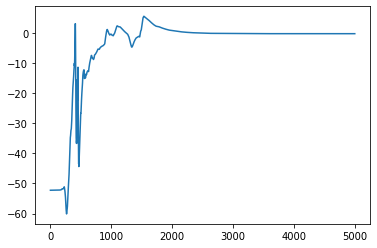

In [15]:
#let's analyze temperature alone
T_Original_gradient=Original_gradients[:,0]
T_TAE_gradients=TAE_gradients[:,0]

Gradient_difference=(T_TAE_gradients-T_Original_gradient)*scaling_factors[0]

plt.plot(Gradient_difference)


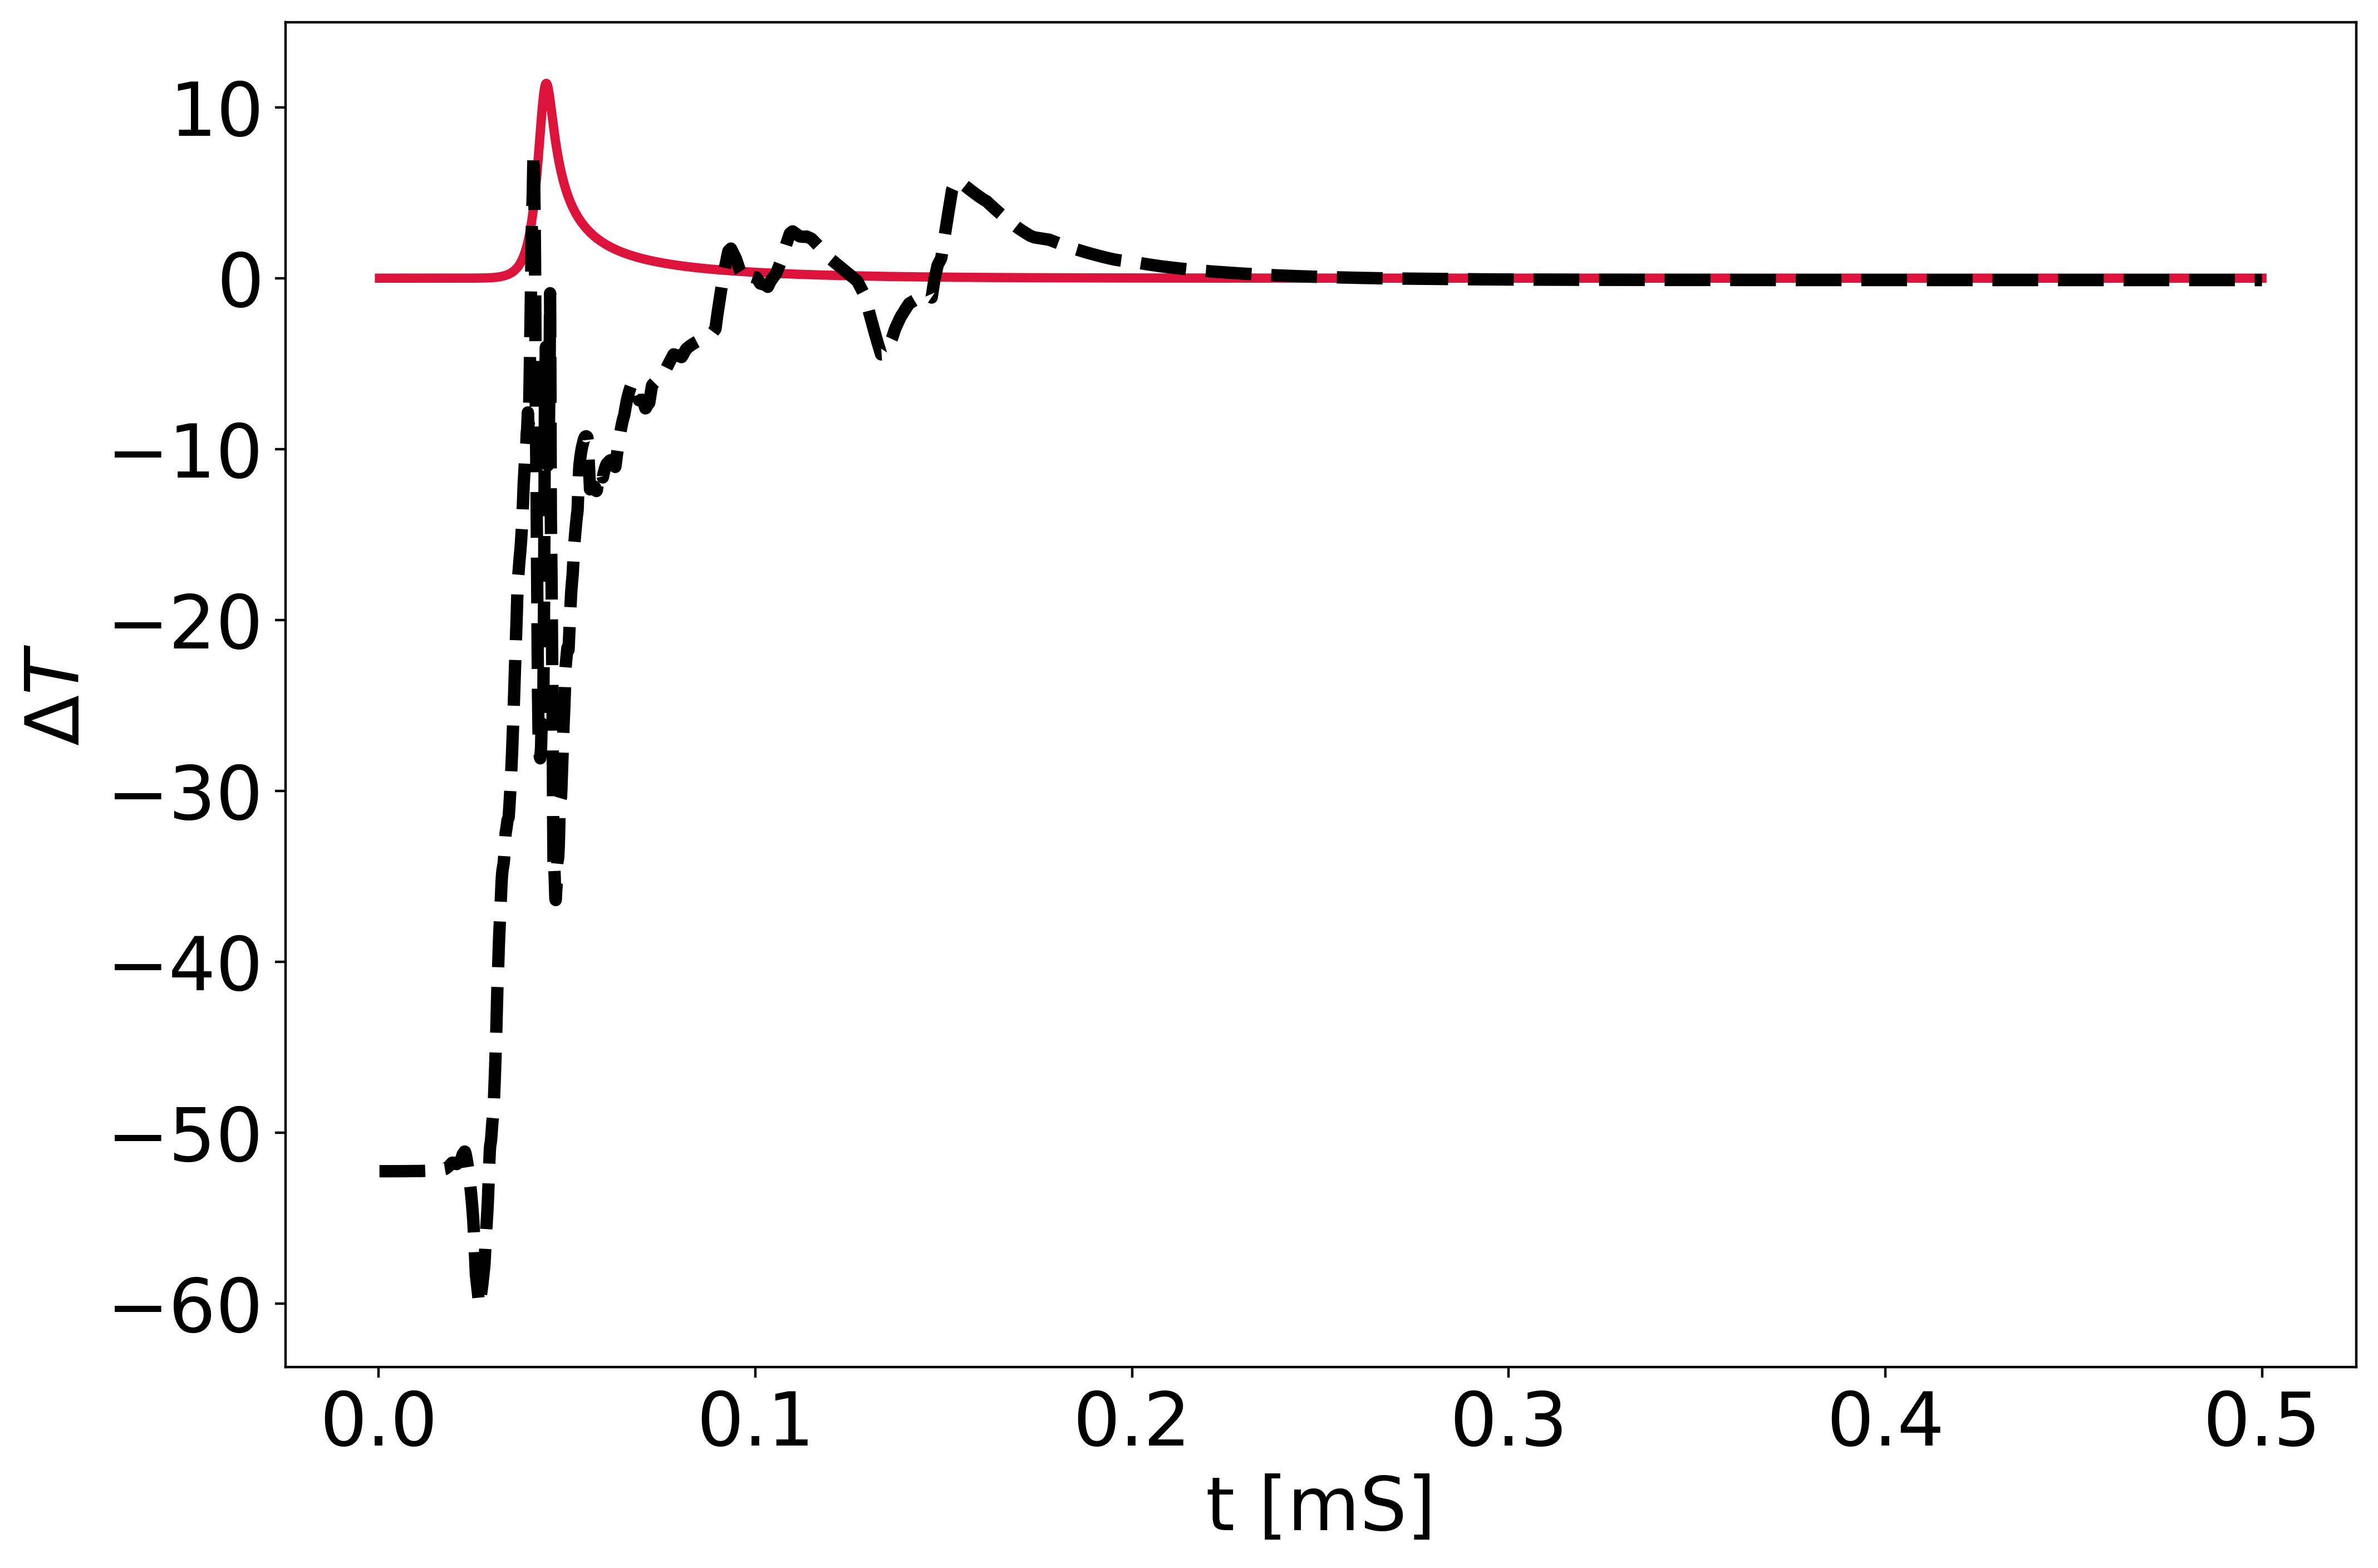

In [16]:

plt.figure(figsize=(12,8),dpi=400)
plt.plot(time_plot*1000,T_Original_gradient*scaling_factors[0],color='crimson', linewidth=3)
plt.plot(time_plot*1000,T_TAE_gradients*scaling_factors[0], color='k', linewidth=4, linestyle='dashed')
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel('t [mS]', fontsize=24)
plt.ylabel('$\Delta T$', fontsize=24)
plt.savefig('temperature_gradients.jpg',dpi=400)